# TDT4173 - Machine Learning Group - Project
This is an explanatory Jupyter Notebook that is intended to show how the Project Group approached the "Solar Energy Production Forecasting" challenge. 

### Table of Contents:
 1. [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-(EDA)) 
 2. [Feature Extraction](#Feature-Extraction) 
 3. [Machine Learning Pipeline](#Machine-Learning-Pipeline) 



## Exploratory Data Analysis (EDA)

In [27]:
%load_ext autoreload
%autoreload 2

# Data Processing Tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Machine Learning Models
import catboost as cb
import h2o 
from h2o.automl import H2OAutoML 


# Machine Learning Tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, OrdinalEncoder



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
def data_length_matching(train: pd.DataFrame, obs: pd.DataFrame)-> tuple[pd.DataFrame, pd.DataFrame]:
    """
    This function is intended to ensure that both the training data and
    the observed data are sorted, and contain the same number of entries. 
    """

    # Cut the data frames so that their date match.
    obs_feature_test = obs[obs['date_forecast'].isin(train['time'])].sort_values(by=['date_forecast'])  # sortert etter datao
    # If only one of them has the date ensure that the other also has the same sorting.
    train_feature_test = train[train['time'].isin(obs['date_forecast'])].sort_values(by=['time'])       # sortert etter datao

    return train_feature_test, obs_feature_test


## Feature Extraction

In [29]:
def square_df(df: pd.DataFrame, timeStamps: str, measurements: list[str]):
    squared_df = pd.DataFrame()
    df = df.copy()
    for measurement in measurements:
        # Calculate derivative estimates
        squared_df['squared_' + measurement + '_2'] = df[measurement]**2
    return squared_df

def upscale_(df: pd.DataFrame, feature: str, upscale: int) -> pd.DataFrame:
    df = df.copy()
    upscale_df = pd.DataFrame()
    
    upscale_df["uscale_" + feature] = df[feature]*upscale

    return upscale_df

def dot_df(df: pd.DataFrame, dot_feature: str, features: list[str]) -> pd.DataFrame:
    df = df.copy()
    dot_df = pd.DataFrame()

    for feature in features:
        dot_df[dot_feature + '_dot_' + feature] = df[dot_feature] * df[feature]

    return dot_df

def log_df(df: pd.DataFrame, features: list[str]):
    
    df = df.copy()
    log_df = pd.DataFrame()

    for feature in features:
        df[feature] = abs(df[feature])
        df[feature] = df[feature] + 1
        log_df['log_' + feature] =  np.log(df[feature])

    return log_df


def difference_df(df: pd.DataFrame, timeStamps: str, measurements: list[str]) -> pd.DataFrame:
    """
    Adds a derivative column to the pandas dataframe. May be used to create time dependency.
    """
    der_df = pd.DataFrame()
    df = df.copy()
    # Sort DataFrame by timestamp
    df = df.sort_values(timeStamps) 

    # Calculate time differences
    df['time_diff'] = df[timeStamps].diff()

    for measurement in measurements:
        # Calculate derivative estimates
        der_df['derivative_' + measurement + '_d'] = df[measurement].diff()
    
    df = df.drop('time_diff', axis =  1)

    # Since the first element will result in a NaN, we must backfill this one.
    der_df = der_df.interpolate(method='linear')
    der_df = der_df.bfill()
    
    return der_df

def double_derivative_from_df(df: pd.DataFrame, timeStamps: str, measurements: list[str]) -> pd.DataFrame:
    """
    Adds a derivative column to the pandas dataframe. May be used to create time dependency.
    """
    dder_df = pd.DataFrame()
    df = df.copy()
    # Sort DataFrame by timestamp
    df = df.sort_values(timeStamps) 

    # Calculate time differences
    df['time_diff'] = df[timeStamps].diff()

    # Calculate derivative estimates
    for measurement in measurements:
        dder_df['double_derivative_' + measurement + '_dd'] = df[measurement].diff() / (divmod(df['time_diff'].dt.total_seconds(), 60)[0]**2)
    
    df = df.drop('time_diff', axis=1)
    
    # Since the first element will result in a NaN, we must backfill this one.
    dder_df = dder_df.interpolate(method='linear')
    dder_df = dder_df.bfill()

    return dder_df

def daily_accumulated_val_df(df: pd.DataFrame, timeStamps: str, measurements: list[str]) -> pd.DataFrame:
    
    i_df = pd.DataFrame()
    df = df.copy()
    # Sort DataFrame by timestamp
    df = df.sort_values(timeStamps)

    # Create a new column for the date
    df['date'] = df[timeStamps].dt.date

    for measurement in measurements:
        # Calculate the integral value for each day
        i_df['integral_' + measurement + '_integral'] = df.groupby('date')[measurement].cumsum()
    
    df = df.drop('date', axis=1)

    return i_df

def daily_accumulated_val_squared_df(df: pd.DataFrame, timeStamps: str, measurements: list[str]) -> pd.DataFrame:
    
    di_df = pd.DataFrame()
    df = df.copy()
    # Sort DataFrame by timestamp
    df = df.sort_values(timeStamps)

    # Create a new column for the date
    df['date'] = df[timeStamps].dt.date

    for measurement in measurements:
        # Calculate the integral value for each day
        di_df['double_integral_' + measurement + '_dintegral'] = df.groupby('date')[measurement].cumsum()**2
    
    df = df.drop('date', axis=1)

    return di_df

def time_data_from_df(df: pd.DataFrame, timestamps: str) -> pd.DataFrame: 
    # Extracting components
    time_df = pd.DataFrame()
    df = df.copy()
    time_df['day_of_year:day'] = df[timestamps].dt.dayofyear
    time_df['month:month'] = df[timestamps].dt.month
    #time_df['year:year'] = df[timestamps].dt.year
    time_df['hour:hour'] = df[timestamps].dt.hour
    return time_df


# Should modify this
def n_largest_freq(df: pd.DataFrame, measurements: list[str],n_largest: int):
    """
    Generates values based on the largest frequencies that are present.
    """
    for measurement in measurements:
        signal = df[measurement].values

        fft_result = np.fft.fft(signal)
        
        
        indices = np.argsort(np.abs(fft_result))[::-1][:n_largest]

        for i, idx in enumerate(indices):
            # Set all other frequency components to zero
            fft_result_filtered = np.zeros_like(fft_result)
            fft_result_filtered[idx] = fft_result[idx]

            # Compute IFFT
            ifft_result = np.fft.ifft(fft_result_filtered)

            # Add the filtered results to the dataframe
            df["filtered_freq_" + str(i) +"_" + measurement] = ifft_result.real

    return df

def freq_comb(df: pd.DataFrame, features: list[str]) -> np.array:
    """
    Takes the fourier transform of multiple signals add them together, and then takes the inverse.

    features: Are what you would like to combine.
    df: Chosen dataframe containing feature information.
    """

    total_fft = 0
    
    for feat in features:
        # Finding the signal directly might be wrong due to timestamps and such, but might still be helpful. It is not correct, but improvements like day by day sampling might be useful.
        signal = df[feat].values

        # Min-max scaling
        scaled_signal = min_max_scale(signal)
        
        fft = np.fft.fft(scaled_signal)
        total_fft = total_fft + fft
    
    ifft_result = np.fft.ifft(total_fft)

    return ifft_result.real

def min_max_scale(signal: np.array) -> np.array:
    # Calculate min and max values
    min_val = np.min(signal)
    max_val = np.max(signal)

    # Min-max scaling
    scaled_signal = (signal - min_val) / (max_val - min_val)

    return scaled_signal

def shifted_values_24_h(y: pd.DataFrame, measurement: str)->pd.DataFrame:
    df = pd.DataFrame()
    for i in range(1, 25):
        df[measurement + 'n-' + str(i)] = y[measurement].shift(i)
    
    return df

def merge_features(df: pd.DataFrame):
    # Extract the part before ":" in column names
    df.columns = df.columns.str.split(':').str[0]

    # Group by modified column names and sum values
    grouped_df = df.groupby(df.columns, axis=1).sum()

    return grouped_df

In [30]:
"""
A couple of functions to generate the approprate features for both training and prediction data.
"""

def train_data_processing(X: pd.DataFrame, y: pd.DataFrame, filter_list: list[str] = [], feedback: bool = False):
   
    # Removing NaN values. If there are missing values treat start and end points as beginning and end of a line.
    X = X.interpolate(method='linear', limit_direction = "both")

    # Extract necesarry values for feature generation.
    timestamps = "date_forecast"
    measurements = list(X.columns.values)
    measurements.remove(timestamps)

    # Probable features that may be used
    squared_df = square_df(X, timestamps, measurements)
    print("Squared")
    print(squared_df.columns.values)
    der_df = difference_df(X, timestamps, measurements)
    print("Derivative")
    print(der_df.columns.values)
    dder_df = double_derivative_from_df(X, timestamps, measurements)
    print("Double Derivative")
    print(dder_df.columns.values)
    int_df = daily_accumulated_val_df(X, timestamps, measurements)
    print("Integral")
    print(int_df.columns.values)
    dint_df = daily_accumulated_val_squared_df(X, timestamps, measurements)
    print("Double Integral")
    print(dint_df.columns.values)
    l_df = log_df(X, measurements)
    print("Log")
    print(l_df.columns.values)
    dotted_df = dot_df(X, 'direct_rad:W', measurements)
    print("Dotted")
    print(dotted_df.columns.values)
    time_df = time_data_from_df(X, timestamps)
    print("Time")
    print(time_df.columns.values)

    X = pd.concat([X, squared_df, der_df, dder_df, dint_df, int_df, l_df, dotted_df, time_df], axis = "columns")

    if len(filter_list) > 0:
        X = X[filter_list + ["date_forecast"]]

    # Additional features
    
    #der_y = difference_df(y, "time", ["pv_measurement"])
    # der_y_shifted = shifted_values_24_h(der_y, "derivative_pv_measurement_d")
    y_shifted =  shifted_values_24_h(y, "pv_measurement")
    y.reset_index(drop = True)
    y_shifted.reset_index(drop = True)
    # Adding together the added features to one dataframe.
    y_BIG = pd.concat([y, y_shifted])
    X.reset_index(drop = True)

    # Making sure that the two dataframes match in length.
    y_BIG, X = data_length_matching(y_BIG, X)

    # Get our desired output
    y = y_BIG["pv_measurement"]
   
    
    if feedback:
        # Removing datetime object column.
        y_features = y_BIG.drop('pv_measurement', axis=1)
        y_features = y_features.drop('time', axis=1)
        y_features = y_features.reset_index(drop = True)
        
        
        y_features = y_features.reset_index(drop = True)
        X = X.reset_index(drop = True)
        X = pd.concat([X, y_features], axis = 1)
        
    
    # Removing datetime object column
    X = X.drop(timestamps, axis=1)
    
    X = X.reset_index(drop = True)

    return X, y

def pred_data_processing(X_pred: pd.DataFrame) -> pd.DataFrame:
    """
    A function that reads
    """
    
    # Removing NaN values. If there are missing values treat start and end points as beginning and end of a line.
    X_pred = X_pred.interpolate(method = 'linear')
    X_pred = X_pred.bfill()

    # Extract necesarry values for feature generation.
    timestamps = "date_forecast"

    # Removing date-time from measurements
    measurements = list(X_pred.columns.values)
    measurements.remove("date_forecast")
    measurements.remove("date_calc")

    # Probable features that may be used
    squared_df = square_df(X_pred, timestamps, measurements)
    der_df = difference_df(X_pred, timestamps, measurements)
    dder_df = double_derivative_from_df(X_pred, timestamps, measurements)
    int_df = daily_accumulated_val_df(X_pred, timestamps, measurements)
    dint_df = daily_accumulated_val_squared_df(X_pred, timestamps, measurements)
    l_df = log_df(X_pred, measurements)
    dotted_df = dot_df(X_pred, 'direct_rad:W', measurements)
    time_df = time_data_from_df(X_pred, timestamps)

    X_pred_new = pd.concat([X_pred, squared_df, der_df, dder_df, dint_df, int_df, l_df, dotted_df, time_df], axis = "columns")

    X_pred_new = X_pred_new.drop("date_calc", axis = 1)
    return X_pred_new


In [31]:
def create_training_and_pred_data(file_paths: list[str]):
    buildings = ['A', 'B', 'C']
    paths = []
    
    for i, path in enumerate(file_paths):
        # Retrieve data        
        y = pd.read_parquet(path[0])
        X_estimated = pd.read_parquet(path[1])
        X_observed = pd.read_parquet(path[2])
        X_pred = pd.read_parquet(path[3])

        # Processing and cleaning data
        y = y.dropna()
        X_estimated = X_estimated.drop("date_calc", axis = 1)
        X = pd.concat([X_observed, X_estimated], axis = 0, ignore_index=True)
        
        X, y= train_data_processing(X, y)
        


        X_pred = pred_data_processing(X_pred)
        
        X_path = buildings[i] + "/" + "X.csv"
        X.to_csv(path_or_buf = X_path, sep='\t')

        y_path = buildings[i] + "/" + "y.csv"
        y.to_csv(path_or_buf = y_path, sep='\t')

        X_pred_path = buildings[i] + "/" + "X_pred.csv"
        X_pred.to_csv(path_or_buf = X_pred_path, sep='\t')
        
        
        paths.append([X_path, y_path, X_pred_path])

    return paths 

def n_smallest(df: pd.DataFrame, column: str, N: int = 10) -> list[float]:
    # Assuming df is your DataFrame and column_name is the column you're interested in
    filtered_df = df[df[column] >= 10]

    # Replace N with the number of lowest non-zero values you want
    
    result = filtered_df.nsmallest(N, column)
    return result

def n_highest(df: pd.DataFrame, column: str, N: int = 10) -> list[float]:
    # Replace N with the number of largest non-zero values you want
    N = 10
    result = df.nlargest(N, column)
    return list(result)





In [33]:
file_paths = [['A/train_targets.parquet', 'A/X_train_estimated.parquet', 'A/X_train_observed.parquet', 'A/X_test_estimated.parquet'],
              ['B/train_targets.parquet', 'B/X_train_estimated.parquet', 'B/X_train_observed.parquet', 'B/X_test_estimated.parquet'],
              ['C/train_targets.parquet', 'C/X_train_estimated.parquet', 'C/X_train_observed.parquet', 'C/X_test_estimated.parquet']]

file_paths = create_training_and_pred_data(file_paths = file_paths)


Squared
['squared_absolute_humidity_2m:gm3_2' 'squared_air_density_2m:kgm3_2'
 'squared_ceiling_height_agl:m_2' 'squared_clear_sky_energy_1h:J_2'
 'squared_clear_sky_rad:W_2' 'squared_cloud_base_agl:m_2'
 'squared_dew_or_rime:idx_2' 'squared_dew_point_2m:K_2'
 'squared_diffuse_rad:W_2' 'squared_diffuse_rad_1h:J_2'
 'squared_direct_rad:W_2' 'squared_direct_rad_1h:J_2'
 'squared_effective_cloud_cover:p_2' 'squared_elevation:m_2'
 'squared_fresh_snow_12h:cm_2' 'squared_fresh_snow_1h:cm_2'
 'squared_fresh_snow_24h:cm_2' 'squared_fresh_snow_3h:cm_2'
 'squared_fresh_snow_6h:cm_2' 'squared_is_day:idx_2'
 'squared_is_in_shadow:idx_2' 'squared_msl_pressure:hPa_2'
 'squared_precip_5min:mm_2' 'squared_precip_type_5min:idx_2'
 'squared_pressure_100m:hPa_2' 'squared_pressure_50m:hPa_2'
 'squared_prob_rime:p_2' 'squared_rain_water:kgm2_2'
 'squared_relative_humidity_1000hPa:p_2' 'squared_sfc_pressure:hPa_2'
 'squared_snow_density:kgm3_2' 'squared_snow_depth:cm_2'
 'squared_snow_drift:idx_2' 'squared

OSError: [Errno 22] Invalid argument: 'B/X.csv'

## Max Value of Day
Predicts when a max value occurs during a day. This to put it simply did not work. It had incredibly poor predictions for all datasets.

In [34]:
# Creates a max indication, and may be used to generate additional features
def max_day_df(y: pd.DataFrame)-> pd.DataFrame:
    y = y.copy()
    df = pd.DataFrame()
    # Group by day and find the max measurement for each day
    y['date'] = y['time'].dt.date 
    df['pv_measurement']  = np.where(y['pv_measurement'] == y.groupby('date')['pv_measurement'].transform('max'), 1, 0)
    df['time'] = y['time']
    return df



In [35]:
# def train_data_processing(X: pd.DataFrame, y: pd.DataFrame, filter_list: list[str] = [], add_feedback: bool = False):
   
#     # Removing NaN values. If there are missing values treat start and end points as beginning and end of a line.
#     X = X.interpolate(method='linear', limit_direction = "both")

#     # Extract necesarry values for feature generation.
#     timestamps = "date_forecast"
#     measurements = list(X.columns.values)
#     measurements.remove(timestamps)

#     # Probable features that may be used
#     squared_df = square_df(X, timestamps, measurements)
#     der_df = difference_df(X, timestamps, measurements)
#     dder_df = double_derivative_from_df(X, timestamps, measurements)
#     int_df = daily_accumulated_val_df(X, timestamps, measurements)
#     dint_df = daily_accumulated_val_squared_df(X, timestamps, measurements)
#     time_df = time_data_from_df(X, timestamps)

#     X = pd.concat([X, squared_df, der_df, dder_df, dint_df, int_df, time_df], axis = "columns")

#     if len(filter_list) > 0:
#         X = X[filter_list + ["date_forecast"]]

#     # Additional features
#     der_y = difference_df(y, "time", ["pv_measurement"])
#     der_y_shifted = shifted_values_24_h(der_y, "derivative_pv_measurement_d")
#     y_shifted =  shifted_values_24_h(y, "pv_measurement")

#     # Adding together the added features to one dataframe.
#     y_BIG = pd.concat([y, der_y_shifted, y_shifted])


#     # Making sure that the two dataframes match in length.
#     y_BIG, X = data_length_matching(y_BIG, X)

#     # Get our desired output
#     y = y_BIG["pv_measurement"]
#     y = y.reset_index(drop = True)
    
    
#     if add_feedback:
#         # Removing datetime object column.
#         y_features = y_BIG.drop('pv_measurement', axis=1)
#         y_features = y_features.drop('time', axis=1)
#         y_features = y_features.reset_index(drop = True)

#         X = pd.concat([X, y_features], axis = 1)
    
#     # Removing datetime object column
#     X = X.drop(timestamps, axis=1)
#     X = X.reset_index(drop = True)

#     return X, y

# def pred_data_processing(X_pred: pd.DataFrame, filter_list: list[str] = []) -> pd.DataFrame:
#     """
#     A function that reads
#     """
    
#     # Removing NaN values. If there are missing values treat start and end points as beginning and end of a line.
#     X_pred = X_pred.interpolate(method = 'linear')
#     X_pred = X_pred.bfill()

#     # Extract necesarry values for feature generation.
#     timestamps = "date_forecast"

#     # Removing date-time from measurements
#     measurements = list(X_pred.columns.values)
#     measurements.remove("date_forecast")
#     measurements.remove("date_calc")

#     # Probable features that may be used
#     squared_df = square_df(X_pred, timestamps, measurements)
#     der_df = difference_df(X_pred, timestamps, measurements)
#     dder_df = double_derivative_from_df(X_pred, timestamps, measurements)
#     int_df = daily_accumulated_val_df(X_pred, timestamps, measurements)
#     dint_df = daily_accumulated_val_squared_df(X_pred, timestamps, measurements)
#     time_df = time_data_from_df(X_pred, timestamps)

    

#     X_pred_new = pd.concat([X_pred, squared_df, der_df, dder_df, dint_df, int_df, time_df], axis = "columns")

#     if len(filter_list) > 0:
#         X_pred_new = X_pred_new[filter_list + ['date_forecast']]
#     else:
#         X_pred_new = X_pred_new.drop("date_calc", axis = 1)

#     return X_pred_new

# class feature_learner:
#     def __init__(self, file_paths: list[list[str]], features: list[str] = [], save_folder: str = "") -> None:
#         self.file_paths = file_paths
#         self.features = features
#         self.save_folder = save_folder + "/"
#         self.buildings = ["A", "B", "C"]

#     def create_training_data_multi_model(self):
#         self.X_train_sets = []
#         self.X_test_sets = []
#         self.y_train_sets = []
#         self.y_test_sets = []
#         self.X_pred_sets = []

#         for i, path in enumerate(self.file_paths):
            
#             y = pd.read_parquet(path[0])
#             X_estimated = pd.read_parquet(path[1])
#             X_observed = pd.read_parquet(path[2])
#             X_pred = pd.read_parquet(path[3])

#             # =================  TEST DATA  ================
#             X_pred = pred_data_processing(X_pred, self.features)
#             X_pred['building'] = i

#             # =================TRAINING DATA================
#             # Pre-process data
#             y = y.dropna()
#             X_estimated = X_estimated.drop("date_calc", axis = 1)
#             X = pd.concat([X_observed, X_estimated], axis = 0, ignore_index=True)
            
#             y = max_day_df(y)

#             # ================= ENSURING DATA LENGTH MATCHES ==================
#             X, y= train_data_processing(X, y, self.features)
            
            
#             # ================= ADD BUILDING FEATURE ================
#             X['building'] = i

#             X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True)

#             # ================= SAVING ALL SETS ======================
#             self.X_train_sets.append(X_train)
#             self.X_test_sets.append(X_test)
#             self.y_train_sets.append(y_train)
#             self.y_test_sets.append(y_test)
#             self.X_pred_sets.append(X_pred)
        
#     def fit_multi_model(self):
        
#         self.models = []

#         for i in range(len(self.X_train_sets)): 
            
#             train_dataset = cb.Pool(self.X_train_sets[i], self.y_train_sets[i])

#             model = cb.CatBoostClassifier(loss_function="Logloss", logging_level='Silent')

#             grid = {'iterations': [100, 150, 200],
#                     'learning_rate': [0.03, 0.1],
#                     'depth': [2, 4, 6, 8],
#                     'l2_leaf_reg': [0.2, 0.5, 1, 3]}
#             model.grid_search(grid, train_dataset, verbose=False)

#             self.models.append(model)

#     def predict_multi_model(self):
#         preds = []
        
#         for i in range(len(self.X_pred_sets)):
#             X_pred = self.X_pred_sets[i].drop('date_forecast', axis = 1)
#             unformated_pred = self.models[i].predict(X_pred)
            
#             unformated_pred_df = pd.DataFrame()
#             unformated_pred_df["date_forecast"] = self.X_pred_sets[i]["date_forecast"]
#             unformated_pred_df["building"] = self.X_pred_sets[i]["building"]

#             replace_dict = {0: 'A', 1: 'B', 2: 'C'}

#             # Use the replace method with the specified column and dictionary
#             unformated_pred_df["building"] = unformated_pred_df["building"].replace(replace_dict)
#             unformated_pred_df["pv_measurement"] = pd.Series(unformated_pred)
            
#             unformated_pred_df.to_csv(self.buildings[i] + "max_pred" + ".csv")

#     def get_performance_multi_model(self) -> None:
        
#         for i in range(len(self.X_test_sets)):
#             pred = self.models[i].predict(self.X_test_sets[i])
#             accuracy = accuracy_score(self.y_test_sets[i], pred)
#             print("SCORE BUILDING " + self.buildings[i])
#             print(f"Accuracy: {accuracy}")

# file_paths = [['A/train_targets.parquet', 'A/X_train_estimated.parquet', 'A/X_train_observed.parquet', 'A/X_test_estimated.parquet'],
#               ['B/train_targets.parquet', 'B/X_train_estimated.parquet', 'B/X_train_observed.parquet', 'B/X_test_estimated.parquet'],
#               ['C/train_targets.parquet', 'C/X_train_estimated.parquet', 'C/X_train_observed.parquet', 'C/X_test_estimated.parquet']]


# features = ["absolute_humidity_2m:gm3", "air_density_2m:kgm3", "ceiling_height_agl:m", "clear_sky_energy_1h:J", 
#            "clear_sky_rad:W", "diffuse_rad:W", "diffuse_rad_1h:J", 
#            "direct_rad:W", "direct_rad_1h:J", "effective_cloud_cover:p", "msl_pressure:hPa", "prob_rime:p", "rain_water:kgm2", "relative_humidity_1000hPa:p",
#            "sun_azimuth:d", "sun_elevation:d", "super_cooled_liquid_water:kgm2", "t_1000hPa:K", "total_cloud_cover:p", 'day_of_year:day', 'month:month', 'hour:hour']


# # Testing the procedure 
# l = feature_learner(file_paths = file_paths, features = features)
# l.create_training_data_multi_model()
# l.fit_multi_model()
# l.get_performance_multi_model()
# l.predict_multi_model()



## Machine Learning Pipeline
Testing different Machine Learning models, and tuning and adjusting features quickly becomes a bother if one does not create helper function and classes. The code bellow is what the Project Group developed during the project. 

In [36]:
file_paths = [["A/X.csv", "A/y.csv", "A/X_pred.csv"],
              ["B/X.csv", "B/y.csv", "B/X_pred.csv"],
              ["C/X.csv", "C/y.csv", "C/X_pred.csv"]]

In [37]:
"""
A class to organize the different steps in the machine learning pipeline. The class contains some nice helper functions
that helps the user gain insight into what features the model finds the most usefull.
"""


class learner:
    def __init__(self, file_paths: list[list[str]], features: list[str] = [], save_folder: str = "", feedback: bool = False) -> None:
        self.file_paths = file_paths
        self.features = features
        self.save_folder = save_folder + "/"
        self.buildings = ["A", "B", "C"]
        self.feedback = feedback

    def create_training_data_multi_model(self):
        self.X_train_sets = []
        self.X_test_sets = []
        self.y_train_sets = []
        self.y_test_sets = []
        self.X_pred_sets = []
        self.y_sets = []

        for i, path in enumerate(self.file_paths):
            
            X = pd.read_csv(path[0], sep='\t')[self.features]
            
            y = pd.read_csv(path[1], sep='\t')['pv_measurement']

            X_pred = pd.read_csv(path[2], sep='\t')[self.features + ["date_forecast"]]
            X_pred["date_forecast"] = pd.to_datetime(X_pred["date_forecast"])
            
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True)
            

            # ================= SAVING ALL SETS ======================
            self.X_train_sets.append(X_train)
            self.X_test_sets.append(X_test)
            self.y_train_sets.append(y_train)
            self.y_test_sets.append(y_test)
            self.X_pred_sets.append(X_pred)
            self.y_sets.append(y)
            


    def create_training_data(self):
        list_y = []
        list_X = []
        list_X_pred = []
        scalers = []
    
        for i, path in enumerate(self.file_paths):
            
            X = pd.read_csv(path[0], sep='\t')[self.features]
            y = pd.read_csv(path[1], sep='\t')['pv_measurement']
            X_pred = pd.read_csv(path[2], sep='\t')[self.features + ["date_forecast"]]
            X_pred["date_forecast"] = pd.to_datetime(X_pred["date_forecast"])

            # =================  TEST DATA  ================
            X_pred['building'] = self.buildings[i]
            
            list_X_pred.append(X_pred)

            # =================TRAINING DATA================
            
            # ADD A FUNCTION TO GENERATE BUILDING FEATURE.
            X['building'] = self.buildings[i]

            list_y.append(y)
            list_X.append(X)

        self.scalers = scalers
        # Add all the lists together. However there is a need to add set
        y = pd.concat(list_y, axis= 0, ignore_index=True)
        X = pd.concat(list_X, axis= 0, ignore_index=True)
        X_pred = pd.concat(list_X_pred, axis = 0, ignore_index=True)
        
        X = X.reset_index(drop=True)
        X_pred = X_pred.reset_index(drop=True)

        
        X_train, X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.15, shuffle=True)
        
        
        self.X_train, self.X_test, self.X_pred = X_train, X_test, X_pred
    
    def fit_multi_model_h2o(self):
        
        h2o.init()
        self.models = []
        
        for i in range(len(self.X_train_sets)):
            train_frame =  pd.concat([self.X_train_sets[i], self.y_train_sets[i]], axis = "columns")
            h2o_frame = h2o.H2OFrame(train_frame)

            x_train_columns = h2o_frame.columns

            model = H2OAutoML(sort_metric='MAE', max_models=10, exclude_algos=["DeepLearning"])

            model.train(x = x_train_columns, y = "pv_measurement", training_frame=h2o_frame)
            self.models.append(model)


    def fit_multi_model(self):
        
        self.models = []

        for i in range(len(self.X_train_sets)): 
            
            train_dataset = cb.Pool(self.X_train_sets[i], self.y_train_sets[i])

            model = cb.CatBoostRegressor(loss_function="MAE", logging_level='Silent')

            grid = {'iterations': [100, 150, 200],
                    'learning_rate': [0.03, 0.1],
                    'depth': [2, 4, 6, 8],
                    'l2_leaf_reg': [0.2, 0.5, 1, 3]}
            model.grid_search(grid, train_dataset, verbose=False)

            self.models.append(model)
        return self.models


    def get_performance_multi_model_h2o(self):
        mae_sum = 0

        for i in range(len(self.X_test_sets)):
            h2o_frame = h2o.H2OFrame(self.X_test_sets[i])

            pred_h2o_frame = self.models[i].predict(h2o_frame)
            pred_df = pred_h2o_frame.as_data_frame()
            pred = pred_df['predict'].to_list()
            mae = (mean_absolute_error(self.y_test_sets[i], np.array(pred)))
            mae_sum = mae + mae_sum

        print("MAE: ", mae_sum)

    def predict_multi_model_h2o(self):
        preds = []
        
        for i in range(len(self.X_pred_sets)):
            h2o_frame = h2o.H2OFrame(self.X_pred_sets[i])

            pred_h2o_frame = self.models[i].predict(h2o_frame)
            pred_df = pred_h2o_frame.as_data_frame()
            X_pred = pred_df['predict'].to_list()
            
            unformated_pred = np.array(X_pred)
            
            unformated_pred_df = pd.DataFrame()
            unformated_pred_df["date_forecast"] = self.X_pred_sets[i]["date_forecast"]
            unformated_pred_df["building"] = self.buildings[i]

            # Use the replace method with the specified column and dictionary
            unformated_pred_df["pv_measurement"] = pd.Series(np.array(unformated_pred))
            unformated_pred_df["pv_measurement"] = unformated_pred_df["pv_measurement"].apply(lambda x: max(0, x))

            unformated_pred_df["pv_measurement"].plot()
            plt.show()

            preds.append(unformated_pred_df)

        unformated_pred_df = pd.concat(preds, axis = 0, ignore_index = True)
        # Should add a save method, so that not all work gets lost 😕
        
        pred = self._format_predictions(unformated_pred_df)
        self._save_predictions(pred)

    def predict_multi_model(self):
        preds = []
        
        for i in range(len(self.X_pred_sets)):
            if self.feedback:
                X_pred_without_feedback = self.X_pred_sets[i].drop('date_forecast', axis = 1)
                pred_list = []
                # First feedback

                
                y_df = self.y_sets[i].to_frame()

                feedback_init_row = shifted_values_24_h(y_df, "pv_measurement").iloc[-1]
                
                feedback_row = feedback_init_row

                

                for j, idx in enumerate(X_pred_without_feedback.index.to_list()):
                   
                    X_pred_with_feedback = pd.concat([X_pred_without_feedback.loc[idx].reset_index(drop=True), feedback_row.reset_index(drop=True)], axis=0, ignore_index=True)
                    
                    feedback = self.models[i].predict(X_pred_with_feedback)
                    
                    # Shift the values to the right
                    feedback_row.iloc[1:] = feedback_row.iloc[:-1].values
                    
                    feedback_row.iloc[0] = feedback
                    pred_list.append(feedback)

                unformated_pred = np.array(pred_list)
                
                series = pd.Series(unformated_pred)
                series.plot()
                plt.show()

            else:
                X_pred = self.X_pred_sets[i].drop('date_forecast', axis = 1)
                unformated_pred = self.models[i].predict(X_pred)

            
            unformated_pred_df = pd.DataFrame()
            unformated_pred_df["date_forecast"] = self.X_pred_sets[i]["date_forecast"]
            unformated_pred_df["building"] = self.buildings[i]

            # Use the replace method with the specified column and dictionary
            unformated_pred_df["pv_measurement"] = pd.Series(10**np.array(unformated_pred))
            unformated_pred_df["pv_measurement"] = unformated_pred_df["pv_measurement"].apply(lambda x: max(0, x))

            unformated_pred_df["pv_measurement"].plot()
            plt.show()

            preds.append(unformated_pred_df)

        unformated_pred_df = pd.concat(preds, axis = 0, ignore_index = True)
        # Should add a save method, so that not all work gets lost :/
        
        pred = self._format_predictions(unformated_pred_df)
        self._save_predictions(pred)

    def get_performance_multi_model(self) -> None:
        mae_sum = 0
        for i in range(len(self.X_test_sets)):
            pred = self.models[i].predict(self.X_test_sets[i])
            pd.Series(pred).plot()
            pd.Series(self.y_test_sets[i]).plot()
            plt.show()
            mae = (mean_absolute_error(self.y_test_sets[i], 10**np.array(pred)))
            mae_sum = mae + mae_sum

        print("Mean absolute error: ", mae_sum/len(self.X_test_sets))



    def fit_model(self) -> None:
        """
        Based on the selected model the class switches between what model is doing the learning. 
        """

        #============ SHOULD BE PLACED WITHIN A LIST OF FUNCTIONS ===================#
        # Add a function that picks between different models, and processes the data based on this
        train_dataset = cb.Pool(self.X_train, self.y_train, cat_features=['building'])

        self.model = cb.CatBoostRegressor(loss_function="MAE", logging_level='Silent')

        grid = {'iterations': [100, 150, 200],
                'learning_rate': [0.03, 0.1],
                'depth': [2, 4, 6, 8],
                'l2_leaf_reg': [0.2, 0.5, 1, 3]}

        self.model.grid_search(grid, train_dataset, verbose=False)
        

    def get_performance(self) -> None:
        pred = self.model.predict(self.X_test)
        pd.Series(pred).plot()
        pd.Series(self.y_test).plot()
        
        mae = (mean_absolute_error(self.y_test, pred))
        print("Mean Abs: {:.2f}".format(mae))

    def predict(self) -> None:
        
        X_pred = self.X_pred.drop('date_forecast', axis = 1)
        unformated_pred = self.model.predict(X_pred)
        
        unformated_pred_df = pd.DataFrame()
        unformated_pred_df["date_forecast"] = self.X_pred["date_forecast"]
        unformated_pred_df["building"] = self.X_pred["building"]

        replace_dict = {0: 'A', 1: 'B', 2: 'C'}

        # Use the replace method with the specified column and dictionary
        unformated_pred_df["building"] = unformated_pred_df["building"].replace(replace_dict)
        plot_ser = pd.Series(unformated_pred)
        plot_ser.plot()
        plt.show()
        unformated_pred_df["pv_measurement"] = pd.Series(unformated_pred)
        unformated_pred_df["pv_measurement"] = unformated_pred_df["pv_measurement"].apply(lambda x: max(0, x))
    
        pred = self._format_predictions(unformated_pred_df)
        self._save_predictions(pred)

    def save_best_features(self, filename: str, N: int = 0):
        if N == 0:
            N = len(self.X_test.columns.values) - 1
        best_features_df = pd.DataFrame()

        feature_importance = self.model.get_feature_importance()

        # Pair feature names with their importance scores
        feature_importance_dict = dict(zip(self.model.feature_names_, feature_importance))

        # Sort features by importance
        sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

        # Print or use the top features
        top_features = sorted_feature_importance[:N]  # Replace N with the number of top features you want
        
        # Saving to list
        labels = list(self.X_test.columns.values)
        best_features = []

        for feat in top_features:
            best_features.append(feat[0])
        
        best_features_df["Model"] = pd.Series(np.array(best_features))

        best_features_df.to_csv("tests/" + self.save_folder + "single_learner" + '.csv', sep ='\t')




    def save_best_features_multi_model(self, filename: str, N: int = 0):
        if N == 0:
            N = len(self.X_test_sets[0].columns.values) - 1
        best_features_df = pd.DataFrame()

        for i, X in enumerate(self.X_test_sets):
           
            feature_importance = self.models[i].get_feature_importance()

            # Pair feature names with their importance scores
            feature_importance_dict = dict(zip(self.models[i].feature_names_, feature_importance))

            # Sort features by importance
            sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

            # Print or use the top features
            top_features = sorted_feature_importance[:N]  # Replace N with the number of top features you want
            
            # Saving to list
            labels = list(X.columns.values)
            best_features = []

            for feat in top_features:
                best_features.append(feat[0])
            
            best_features_df["Model " + self.buildings[i]] = pd.Series(np.array(best_features))

        best_features_df.to_csv("tests/" + self.save_folder + filename + '.csv', sep ='\t')


    def _format_predictions(self, unformated_pred: pd.DataFrame) -> pd.DataFrame:
        
        # 
        to_be_submitted_index = pd.read_csv("test.csv")

        #convert the "time" column to datetime
        to_be_submitted_index["time"] = pd.to_datetime(to_be_submitted_index["time"])
        pred = pd.merge(unformated_pred, to_be_submitted_index, how='inner', left_on=['date_forecast', 'building'], right_on=["time", "location"])
        
        return pred
        
        
    def _save_predictions(self, pred: pd.DataFrame)->None:
        #Make the index and pv_measurement column into a csv file
        pred[["id", "pv_measurement"]].rename(columns={"id" : "id" , "pv_measurement" : "prediction"}).to_csv("tests/" + self.save_folder + "model_pred.csv", index=False)



This is where the user may apply their testing setup. Here they may apply what features they need, and the model will ensure the rest.

TODO: Dot signals

TODO: Add log of signals

TODO: Sin of signals and dot them :/

TODO: Test adding the best features.

IDEA: The directions may be helpfull. Create a number that tells us more about the sun position. Break it down into breakpoints between them /:


## Features to test

In [38]:
sqared_features = ['squared_absolute_humidity_2m:gm3_2', 'squared_air_density_2m:kgm3_2',
 'squared_ceiling_height_agl:m_2', 'squared_clear_sky_energy_1h:J_2',
 'squared_clear_sky_rad:W_2', 'squared_cloud_base_agl:m_2',
 'squared_dew_or_rime:idx_2', 'squared_dew_point_2m:K_2',
 'squared_diffuse_rad:W_2', 'squared_diffuse_rad_1h:J_2',
 'squared_direct_rad:W_2', 'squared_direct_rad_1h:J_2',
 'squared_effective_cloud_cover:p_2', 'squared_elevation:m_2',
 'squared_fresh_snow_12h:cm_2', 'squared_fresh_snow_1h:cm_2',
 'squared_fresh_snow_24h:cm_2', 'squared_fresh_snow_3h:cm_2',
 'squared_fresh_snow_6h:cm_2', 'squared_is_day:idx_2',
 'squared_is_in_shadow:idx_2', 'squared_msl_pressure:hPa_2',
 'squared_precip_5min:mm_2', 'squared_precip_type_5min:idx_2',
 'squared_pressure_100m:hPa_2', 'squared_pressure_50m:hPa_2',
 'squared_prob_rime:p_2', 'squared_rain_water:kgm2_2',
 'squared_relative_humidity_1000hPa:p_2', 'squared_sfc_pressure:hPa_2',
 'squared_snow_density:kgm3_2', 'squared_snow_depth:cm_2',
 'squared_snow_drift:idx_2','squared_snow_melt_10min:mm_2',
 'squared_snow_water:kgm2_2', 'squared_sun_azimuth:d_2',
 'squared_sun_elevation:d_2', 'squared_super_cooled_liquid_water:kgm2_2',
 'squared_t_1000hPa:K_2', 'squared_total_cloud_cover:p_2',
 'squared_visibility:m_2', 'squared_wind_speed_10m:ms_2',
 'squared_wind_speed_u_10m:ms_2', 'squared_wind_speed_v_10m:ms_2',
 'squared_wind_speed_w_1000hPa:ms_2']

derivative_features = ['derivative_absolute_humidity_2m:gm3_d',
 'derivative_air_density_2m:kgm3_d', 'derivative_ceiling_height_agl:m_d',
 'derivative_clear_sky_energy_1h:J_d', 'derivative_clear_sky_rad:W_d',
 'derivative_cloud_base_agl:m_d', 'derivative_dew_or_rime:idx_d',
 'derivative_dew_point_2m:K_d', 'derivative_diffuse_rad:W_d',
 'derivative_diffuse_rad_1h:J_d', 'derivative_direct_rad:W_d',
 'derivative_direct_rad_1h:J_d', 'derivative_effective_cloud_cover:p_d',
 'derivative_elevation:m_d', 'derivative_fresh_snow_12h:cm_d',
 'derivative_fresh_snow_1h:cm_d', 'derivative_fresh_snow_24h:cm_d',
 'derivative_fresh_snow_3h:cm_d', 'derivative_fresh_snow_6h:cm_d',
 'derivative_is_day:idx_d', 'derivative_is_in_shadow:idx_d',
 'derivative_msl_pressure:hPa_d', 'derivative_precip_5min:mm_d',
 'derivative_precip_type_5min:idx_d', 'derivative_pressure_100m:hPa_d',
 'derivative_pressure_50m:hPa_d', 'derivative_prob_rime:p_d',
 'derivative_rain_water:kgm2_d', 'derivative_relative_humidity_1000hPa:p_d',
 'derivative_sfc_pressure:hPa_d', 'derivative_snow_density:kgm3_d',
 'derivative_snow_depth:cm_d', 'derivative_snow_drift:idx_d',
 'derivative_snow_melt_10min:mm_d', 'derivative_snow_water:kgm2_d',
 'derivative_sun_azimuth:d_d', 'derivative_sun_elevation:d_d',
 'derivative_super_cooled_liquid_water:kgm2_d', 'derivative_t_1000hPa:K_d',
 'derivative_total_cloud_cover:p_d', 'derivative_visibility:m_d',
 'derivative_wind_speed_10m:ms_d', 'derivative_wind_speed_u_10m:ms_d',
 'derivative_wind_speed_v_10m:ms_d', 'derivative_wind_speed_w_1000hPa:ms_d']

double_integral_features = ['double_derivative_absolute_humidity_2m:gm3_dd',
 'double_derivative_air_density_2m:kgm3_dd',
 'double_derivative_ceiling_height_agl:m_dd',
 'double_derivative_clear_sky_energy_1h:J_dd',
 'double_derivative_clear_sky_rad:W_dd',
 'double_derivative_cloud_base_agl:m_dd',
 'double_derivative_dew_or_rime:idx_dd',
 'double_derivative_dew_point_2m:K_dd',
 'double_derivative_diffuse_rad:W_dd',
 'double_derivative_diffuse_rad_1h:J_dd',
 'double_derivative_direct_rad:W_dd',
 'double_derivative_direct_rad_1h:J_dd',
 'double_derivative_effective_cloud_cover:p_dd',
 'double_derivative_elevation:m_dd',
 'double_derivative_fresh_snow_12h:cm_dd',
 'double_derivative_fresh_snow_1h:cm_dd',
 'double_derivative_fresh_snow_24h:cm_dd',
 'double_derivative_fresh_snow_3h:cm_dd',
 'double_derivative_fresh_snow_6h:cm_dd', 'double_derivative_is_day:idx_dd',
 'double_derivative_is_in_shadow:idx_dd',
 'double_derivative_msl_pressure:hPa_dd',
 'double_derivative_precip_5min:mm_dd',
 'double_derivative_precip_type_5min:idx_dd',
 'double_derivative_pressure_100m:hPa_dd',
 'double_derivative_pressure_50m:hPa_dd',
 'double_derivative_prob_rime:p_dd', 'double_derivative_rain_water:kgm2_dd',
 'double_derivative_relative_humidity_1000hPa:p_dd',
 'double_derivative_sfc_pressure:hPa_dd',
 'double_derivative_snow_density:kgm3_dd',
 'double_derivative_snow_depth:cm_dd',
 'double_derivative_snow_drift:idx_dd',
 'double_derivative_snow_melt_10min:mm_dd',
 'double_derivative_snow_water:kgm2_dd',
 'double_derivative_sun_azimuth:d_dd',
 'double_derivative_sun_elevation:d_dd',
 'double_derivative_super_cooled_liquid_water:kgm2_dd',
 'double_derivative_t_1000hPa:K_dd',
 'double_derivative_total_cloud_cover:p_dd',
 'double_derivative_visibility:m_dd',
 'double_derivative_wind_speed_10m:ms_dd',
 'double_derivative_wind_speed_u_10m:ms_dd',
 'double_derivative_wind_speed_v_10m:ms_dd',
 'double_derivative_wind_speed_w_1000hPa:ms_dd']
 
integral_features = ['integral_absolute_humidity_2m:gm3_integral',
 'integral_air_density_2m:kgm3_integral',
 'integral_ceiling_height_agl:m_integral',
 'integral_clear_sky_energy_1h:J_integral',
 'integral_clear_sky_rad:W_integral', 'integral_cloud_base_agl:m_integral',
 'integral_dew_or_rime:idx_integral', 'integral_dew_point_2m:K_integral',
 'integral_diffuse_rad:W_integral', 'integral_diffuse_rad_1h:J_integral',
 'integral_direct_rad:W_integral', 'integral_direct_rad_1h:J_integral',
 'integral_effective_cloud_cover:p_integral',
 'integral_elevation:m_integral', 'integral_fresh_snow_12h:cm_integral',
 'integral_fresh_snow_1h:cm_integral',
 'integral_fresh_snow_24h:cm_integral',
 'integral_fresh_snow_3h:cm_integral', 'integral_fresh_snow_6h:cm_integral',
 'integral_is_day:idx_integral', 'integral_is_in_shadow:idx_integral',
 'integral_msl_pressure:hPa_integral', 'integral_precip_5min:mm_integral',
 'integral_precip_type_5min:idx_integral',
 'integral_pressure_100m:hPa_integral',
 'integral_pressure_50m:hPa_integral', 'integral_prob_rime:p_integral',
 'integral_rain_water:kgm2_integral',
 'integral_relative_humidity_1000hPa:p_integral',
 'integral_sfc_pressure:hPa_integral',
 'integral_snow_density:kgm3_integral', 'integral_snow_depth:cm_integral',
 'integral_snow_drift:idx_integral', 'integral_snow_melt_10min:mm_integral',
 'integral_snow_water:kgm2_integral', 'integral_sun_azimuth:d_integral',
 'integral_sun_elevation:d_integral',
 'integral_super_cooled_liquid_water:kgm2_integral',
 'integral_t_1000hPa:K_integral', 'integral_total_cloud_cover:p_integral',
 'integral_visibility:m_integral', 'integral_wind_speed_10m:ms_integral',
 'integral_wind_speed_u_10m:ms_integral',
 'integral_wind_speed_v_10m:ms_integral',
 'integral_wind_speed_w_1000hPa:ms_integral']

double_integral_features = ['double_integral_absolute_humidity_2m:gm3_dintegral',
 'double_integral_air_density_2m:kgm3_dintegral',
 'double_integral_ceiling_height_agl:m_dintegral',
 'double_integral_clear_sky_energy_1h:J_dintegral',
 'double_integral_clear_sky_rad:W_dintegral',
 'double_integral_cloud_base_agl:m_dintegral',
 'double_integral_dew_or_rime:idx_dintegral',
 'double_integral_dew_point_2m:K_dintegral',
 'double_integral_diffuse_rad:W_dintegral',
 'double_integral_diffuse_rad_1h:J_dintegral',
 'double_integral_direct_rad:W_dintegral',
 'double_integral_direct_rad_1h:J_dintegral',
 'double_integral_effective_cloud_cover:p_dintegral',
 'double_integral_elevation:m_dintegral',
 'double_integral_fresh_snow_12h:cm_dintegral',
 'double_integral_fresh_snow_1h:cm_dintegral',
 'double_integral_fresh_snow_24h:cm_dintegral',
 'double_integral_fresh_snow_3h:cm_dintegral',
 'double_integral_fresh_snow_6h:cm_dintegral',
 'double_integral_is_day:idx_dintegral',
 'double_integral_is_in_shadow:idx_dintegral',
 'double_integral_msl_pressure:hPa_dintegral',
 'double_integral_precip_5min:mm_dintegral',
 'double_integral_precip_type_5min:idx_dintegral',
 'double_integral_pressure_100m:hPa_dintegral',
 'double_integral_pressure_50m:hPa_dintegral',
 'double_integral_prob_rime:p_dintegral',
 'double_integral_rain_water:kgm2_dintegral',
 'double_integral_relative_humidity_1000hPa:p_dintegral',
 'double_integral_sfc_pressure:hPa_dintegral',
 'double_integral_snow_density:kgm3_dintegral',
 'double_integral_snow_depth:cm_dintegral',
 'double_integral_snow_drift:idx_dintegral',
 'double_integral_snow_melt_10min:mm_dintegral',
 'double_integral_snow_water:kgm2_dintegral',
 'double_integral_sun_azimuth:d_dintegral',
 'double_integral_sun_elevation:d_dintegral',
 'double_integral_super_cooled_liquid_water:kgm2_dintegral',
 'double_integral_t_1000hPa:K_dintegral',
 'double_integral_total_cloud_cover:p_dintegral',
 'double_integral_visibility:m_dintegral',
 'double_integral_wind_speed_10m:ms_dintegral',
 'double_integral_wind_speed_u_10m:ms_dintegral',
 'double_integral_wind_speed_v_10m:ms_dintegral',
 'double_integral_wind_speed_w_1000hPa:ms_dintegral']

log_features = ['log_absolute_humidity_2m:gm3', 'log_air_density_2m:kgm3',
 'log_ceiling_height_agl:m', 'log_clear_sky_energy_1h:J',
 'log_clear_sky_rad:W', 'log_cloud_base_agl:m', 'log_dew_or_rime:idx',
 'log_dew_point_2m:K', 'log_diffuse_rad:W', 'log_diffuse_rad_1h:J',
 'log_direct_rad:W', 'log_direct_rad_1h:J', 'log_effective_cloud_cover:p',
 'log_elevation:m', 'log_fresh_snow_12h:cm', 'log_fresh_snow_1h:cm',
 'log_fresh_snow_24h:cm', 'log_fresh_snow_3h:cm', 'log_fresh_snow_6h:cm',
 'log_is_day:idx', 'log_is_in_shadow:idx', 'log_msl_pressure:hPa',
 'log_precip_5min:mm', 'log_precip_type_5min:idx', 'log_pressure_100m:hPa',
 'log_pressure_50m:hPa', 'log_prob_rime:p' ,'log_rain_water:kgm2',
 'log_relative_humidity_1000hPa:p', 'log_sfc_pressure:hPa',
 'log_snow_density:kgm3', 'log_snow_depth:cm', 'log_snow_drift:idx',
 'log_snow_melt_10min:mm', 'log_snow_water:kgm2', 'log_sun_azimuth:d',
 'log_sun_elevation:d', 'log_super_cooled_liquid_water:kgm2',
 'log_t_1000hPa:K', 'log_total_cloud_cover:p', 'log_visibility:m',
 'log_wind_speed_10m:ms', 'log_wind_speed_u_10m:ms',
 'log_wind_speed_v_10m:ms', 'log_wind_speed_w_1000hPa:ms']

dotted_features = ['direct_rad:W_dot_absolute_humidity_2m:gm3',
 'direct_rad:W_dot_air_density_2m:kgm3',
 'direct_rad:W_dot_ceiling_height_agl:m',
 'direct_rad:W_dot_clear_sky_energy_1h:J',
 'direct_rad:W_dot_clear_sky_rad:W', 'direct_rad:W_dot_cloud_base_agl:m',
 'direct_rad:W_dot_dew_or_rime:idx', 'direct_rad:W_dot_dew_point_2m:K',
 'direct_rad:W_dot_diffuse_rad:W', 'direct_rad:W_dot_diffuse_rad_1h:J',
 'direct_rad:W_dot_direct_rad:W', 'direct_rad:W_dot_direct_rad_1h:J',
 'direct_rad:W_dot_effective_cloud_cover:p', 'direct_rad:W_dot_elevation:m'
 'direct_rad:W_dot_fresh_snow_12h:cm' ,'direct_rad:W_dot_fresh_snow_1h:cm',
 'direct_rad:W_dot_fresh_snow_24h:cm' ,'direct_rad:W_dot_fresh_snow_3h:cm',
 'direct_rad:W_dot_fresh_snow_6h:cm' ,'direct_rad:W_dot_is_day:idx',
 'direct_rad:W_dot_is_in_shadow:idx', 'direct_rad:W_dot_msl_pressure:hPa',
 'direct_rad:W_dot_precip_5min:mm', 'direct_rad:W_dot_precip_type_5min:idx',
 'direct_rad:W_dot_pressure_100m:hPa', 'direct_rad:W_dot_pressure_50m:hPa',
 'direct_rad:W_dot_prob_rime:p', 'direct_rad:W_dot_rain_water:kgm2',
 'direct_rad:W_dot_relative_humidity_1000hPa:p',
 'direct_rad:W_dot_sfc_pressure:hPa' ,'direct_rad:W_dot_snow_density:kgm3',
 'direct_rad:W_dot_snow_depth:cm' ,'direct_rad:W_dot_snow_drift:idx',
 'direct_rad:W_dot_snow_melt_10min:mm' ,'direct_rad:W_dot_snow_water:kgm2',
 'direct_rad:W_dot_sun_azimuth:d' ,'direct_rad:W_dot_sun_elevation:d',
 'direct_rad:W_dot_super_cooled_liquid_water:kgm2',
 'direct_rad:W_dot_t_1000hPa:K', 'direct_rad:W_dot_total_cloud_cover:p',
 'direct_rad:W_dot_visibility:m' ,'direct_rad:W_dot_wind_speed_10m:ms',
 'direct_rad:W_dot_wind_speed_u_10m:ms',
 'direct_rad:W_dot_wind_speed_v_10m:ms',
 'direct_rad:W_dot_wind_speed_w_1000hPa:ms']

time_features = ['day_of_year:day', 'month:month', 'hour:hour']


Mean Abs: 93.38


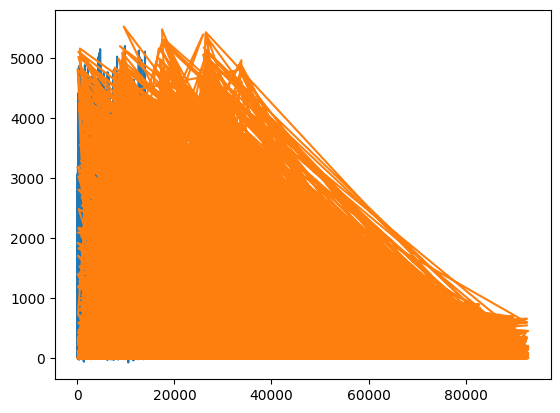

In [39]:
 
features = log_features + time_features

l = learner(file_paths = file_paths, features = features)
l.create_training_data()
l.fit_model()
l.get_performance()



In [40]:
l.save_best_features("dsad")
l.predict()

NameError: name 'X' is not defined